# **Preliminaries:** Install and import modules

In [1]:
#@title [RUN] install
!pip install networkx
!pip install mycolorpy
!pip install colorama


import torch
!pip install torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html


In [2]:
#@title [RUN] Import modules
import numpy as np
import seaborn as sns
import math
import itertools
import scipy as sp
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import Planetoid, ZINC, GNNBenchmarkDataset
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils import to_dense_adj
from torch.nn import Embedding

import pdb
from datetime import datetime

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

from mycolorpy import colorlist as mcp
import matplotlib.cm as cm

from typing import Mapping, Tuple, Sequence, List
import colorama

import scipy.linalg
from scipy.linalg import block_diag

In [3]:
####### PLOTS #######

def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats

def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))

def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)
    
    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))

# Cora dataset



In [4]:
cora_dataset = Planetoid("/tmp/cora", name="cora", split="full")
cora_data = cora_dataset[0]

In [5]:
print("Training class sizes")
print(torch.bincount(cora_dataset[0].y[cora_dataset[0].train_mask]))
print("Validation class sizes")
print(torch.bincount(cora_dataset[0].y[cora_dataset[0].val_mask]))
print("Test class sizes")
print(torch.bincount(cora_dataset[0].y[cora_dataset[0].test_mask]))

Training class sizes
tensor([160,  90, 196, 341, 196, 138,  87])
Validation class sizes
tensor([ 61,  36,  78, 158,  81,  57,  29])
Test class sizes
tensor([130,  91, 144, 319, 149, 103,  64])


# Data saving / loading

In [6]:
# use google drive for saving and loading information
from google.colab import drive
import pickle
import os

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/L45_project/'
# create folder if it does not exist already
if not os.path.exists(file_path):
  os.mkdir(file_path) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def save_training_info(training_stats: dict, node_embedding: torch.Tensor, filename: str):
  # write training data info to a file
  with open(file_path + filename + ".pkl", 'wb') as fp:
    pickle.dump(training_stats, fp)
    print('Training stats saved successfully to file: ' + filename)
  # write node embedding to a file
  torch.save(node_embedding, file_path + filename + ".pt")
  print('Node embedding saved successfully to file: ' + filename)


def load_training_info(filename: str):
  # load training stats dictionary 
  with open(file_path + filename + ".pkl", 'rb') as fp:
    train_stats = pickle.load(fp)
    print('Training stats successfully loaded from file: ' + filename)
  # load node embedding
  node_embedding = torch.load(file_path + filename + ".pt")
  print('Node embedding successfully loaded from file: ' + filename)
  return train_stats, node_embedding

# Final results is a list [seed, test result, [test per class accuracy], [training per class accuracy], [val per class accuracy]]
def save_final_results(final_results: List, filename: str):
  # write training data info to a file
  with open(file_path + filename + ".pkl", 'ab') as fp:
    pickle.dump(final_results, fp)
    print('Final results saved successfully to file: ' + filename)

# Returns an iterator which contains all the results from our various runs
def load_final_results(filename: str):
  with open(file_path + filename + ".pkl", 'rb') as fp:
    print('Final results found in file: ' + filename)
    while True:
      try:
        # This notation creates a generator, which we can then iterate through
        yield pickle.load(fp)
      except EOFError:
        break


In [8]:
test_dict = {'c':[1,2,3], 'b':[4,5,6]}
test_tensor = torch.tensor([[1., -1.], [1., -1.]])
save_training_info(test_dict, test_tensor, "testing")
recovered_val1, recovered_val2 = load_training_info("testing")
print(recovered_val1, recovered_val2)

Training stats saved successfully to file: testing
Node embedding saved successfully to file: testing
Training stats successfully loaded from file: testing
Node embedding successfully loaded from file: testing
{'c': [1, 2, 3], 'b': [4, 5, 6]} tensor([[ 1., -1.],
        [ 1., -1.]])


# Model Wrappers

In [9]:
from torch_geometric.nn import GCN
from torch_geometric.typing import Adj

class GCNModelWrapper(GCN):

  def __init__(self, in_channels: int, hidden_channels: int, num_layers: int, out_channels: int):
    # use one less layer as our final graph layer can downsize for us
    # super().__init__(in_channels, hidden_channels, num_layers-1)
    super().__init__(in_channels, hidden_channels, num_layers)
    self.out_channels = out_channels
    # self.final_layer = self.init_conv(in_channels, out_channels)
    self.final_layer = nn.Linear(in_channels, out_channels)

  def forward(self, x: torch.Tensor, edge_index: Adj):
    x = super().forward(x, edge_index)
    # output = self.final_layer(x, edge_index)
    output = self.final_layer(x)
    return output


In [10]:
from torch_geometric.nn import GAT

class GATModelWrapper(GAT):

  def __init__(self, in_channels: int, hidden_channels: int, num_layers: int, out_channels: int, v2: bool):
    # Create the model to extract the node embeddings then pass these through a linear layer for classification
    super().__init__(in_channels, hidden_channels, num_layers, v2=v2)
    self.out_channels = out_channels
    self.final_layer = nn.Linear(in_channels, out_channels)

  def forward(self, x: torch.Tensor, edge_index: Adj):
    x = super().forward(x, edge_index)
    output = self.final_layer(x)
    return output, x

# Training code



In [11]:
# @title [RUN] Hyperparameters GNN

NUM_EPOCHS =  10 #@param {type:"integer"}
LR         = 0.01 #@param {type:"number"}

#you can add more here if you need

In [12]:
# Code taken from L45 practical notebook
def train_gnn_cora(X, edge_indices, y, mask, model, optimiser):
    model.train()
    optimiser.zero_grad()
    #y_out, _ = model(X, edge_indices)
    y_out, _ = model(X)
    y_hat = y_out[mask]
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data

def evaluate_gnn_cora(X, edge_indices, y, mask, model, num_classes):
    model.eval()
    y_out, node_embeddings = model(X, edge_indices)
    y_hat = y_out[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)

    # calculate per class accuracy
    values, counts = torch.unique(y_hat[y_hat == y.data], return_counts=True)
    per_class_counts = torch.zeros(num_classes)
    # allocate the number of counts per class
    for i, x in enumerate(values):
      per_class_counts[x] = counts[i]
    # find total number of data points per class in the split
    total_per_class = torch.bincount(y.data)
    per_class_accuracy = torch.div(per_class_counts, total_per_class)

    return accuracy, per_class_accuracy, node_embeddings
    
# Training loop
def train_eval_loop_gnn_cora(model, edge_indices, train_x, train_y, train_mask, valid_x, valid_y, valid_mask, 
                             test_x, test_y, test_mask, num_classes, seed, filename):
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_gnn_cora(train_x, edge_indices, train_y, train_mask, model, optimiser)
        train_acc, train_class_acc, _ = evaluate_gnn_cora(train_x, edge_indices, train_y, train_mask, model, num_classes)
        valid_acc, valid_class_acc, _ = evaluate_gnn_cora(valid_x, edge_indices, valid_y, valid_mask, model, num_classes)
        if epoch % 10 == 0 or epoch == (NUM_EPOCHS-1):
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f} validation accuracy: {valid_acc:.3f}")
            print("Per class train accuracy: ", train_class_acc)
            print("Per class val accuracy: ", valid_class_acc)
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)

    # Lets look at our final test performance
    # Only need to get the node embeddings once, take from the training evaluation call
    test_acc, test_class_acc, node_embeddings = evaluate_gnn_cora(test_x, edge_indices, test_y, test_mask, model, num_classes)
    print(f"Our final test accuracy for the GNN is: {test_acc:.3f}")
    print("Final per class accuracy on test set: ", test_class_acc)

    # Save training stats if on final iteration of the run
    save_training_info(training_stats, node_embeddings, filename+"_"+str(seed))
    # Save final results
    final_results_list = [seed, test_acc, test_class_acc, train_class_acc, valid_class_acc]
    save_final_results(final_results_list, filename)
    # Save final model weights incase we want to do further inference later
    torch.save(model.state_dict(), file_path+filename+"_" + str(seed) + "_model.pt")
    return training_stats

In [13]:
def set_seeds(seed):
  print("SETTING SEEDS TO: ", str(seed))
  # seed the potential sources of randomness
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

SETTING SEEDS TO:  1
TRAINING WITH SEED:  1
Epoch 0 with train loss: 1.951 train accuracy: 44.536 validation accuracy: 43.200
Per class train accuracy:  tensor([0.0812, 0.0000, 0.5714, 1.0000, 0.3265, 0.0580, 0.0000])
Per class val accuracy:  tensor([0.0328, 0.0000, 0.4615, 1.0000, 0.2346, 0.0175, 0.0000])
Epoch 9 with train loss: 0.024 train accuracy: 99.255 validation accuracy: 82.200
Per class train accuracy:  tensor([0.9875, 1.0000, 1.0000, 0.9912, 0.9898, 0.9928, 0.9885])
Per class val accuracy:  tensor([0.7213, 0.7500, 0.9103, 0.8291, 0.8642, 0.8246, 0.7241])
Our final test accuracy for the GNN is: 83.200
Final per class accuracy on test set:  tensor([0.7769, 0.7473, 0.9028, 0.8715, 0.8389, 0.7961, 0.7500])
Training stats saved successfully to file: GATV2/GATV2_1
Node embedding saved successfully to file: GATV2/GATV2_1
Final results saved successfully to file: GATV2/GATV2
SETTING SEEDS TO:  2
TRAINING WITH SEED:  2
Epoch 0 with train loss: 1.950 train accuracy: 45.116 validation 

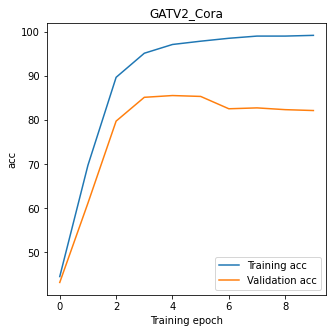

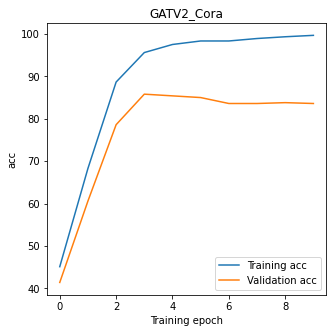

In [ ]:
# Get the edge indices and node features for our model
edge_indices = cora_data.edge_index
node_features = cora_data.x

# Get masks and training labels for each split
train_mask = cora_data.train_mask
train_y = cora_data.y[train_mask]
valid_mask = cora_data.val_mask
valid_y = cora_data.y[valid_mask]
test_mask = cora_data.test_mask
test_y = cora_data.y[test_mask]


num_classes = 7
# CHANGE: To name of model being tested
filename = "GATV2"
# use 30 seeds which have been randomly generated using seed_list = [np.random.randint(4294967296 - 1) for i in range(30)]
seeds = [4193977854, 1863727779, 170173784, 2342954646, 116846604, 2105922959, 2739899259, 1024258131, 806299656, 880019963, 1818027900, 2135956485, 3710910636, 1517964140, 4083009686, 2455059856, 400225693, 89475662, 361232447, 3647665043, 1221215631, 2036056847, 1860537279, 516507873, 3692371949, 3300171104, 2794978777, 3303475786, 2952735006, 572297925]

# create folder for saving all model info into if it does not exist already
if not os.path.exists(file_path+filename+"/"):
  os.mkdir(file_path+filename+"/")

for seed in seeds:
  set_seeds(seed)
  # Create the model
  model = GATModelWrapper(in_channels = node_features.shape[-1], hidden_channels = node_features.shape[-1], num_layers=1, out_channels=num_classes, v2=True)

  # Run training loop
  print("TRAINING WITH SEED: ", str(seed))
  train_stats_cora = train_eval_loop_gnn_cora(model, edge_indices, node_features, train_y, train_mask, 
                                            node_features, valid_y, valid_mask, node_features, test_y, test_mask, num_classes, seed, filename+"/"+filename)
  plot_stats(train_stats_cora, name=filename+"_Cora")

# TESTING LOADING

In [ ]:
final_results = load_final_results(filename)
for r in final_results:
  print(r)

Final results found in file: GATV2
[1, tensor(83.1000), tensor([0.7615, 0.7473, 0.8750, 0.8809, 0.8389, 0.8058, 0.7656]), tensor([0.9875, 0.9889, 1.0000, 0.9912, 0.9898, 0.9928, 0.9770]), tensor([0.7213, 0.7778, 0.8974, 0.8354, 0.8642, 0.8246, 0.7241])]
[2, tensor(82.), tensor([0.7615, 0.6593, 0.9028, 0.8777, 0.8188, 0.7767, 0.7656]), tensor([1.0000, 0.9889, 1.0000, 0.9883, 0.9898, 1.0000, 0.9885]), tensor([0.7213, 0.7778, 0.9231, 0.8608, 0.8519, 0.8421, 0.7586])]


Training stats successfully loaded from file: GATV2_1
Node embedding successfully loaded from file: GATV2_1
tensor([[ 0.3694, -0.3698,  0.2766,  ...,  0.3216,  0.2274,  0.0202],
        [ 0.3314, -0.0802, -0.3007,  ...,  0.7356,  0.0207,  0.6433],
        [ 0.3232, -0.0492, -0.2139,  ...,  0.7058,  0.0322,  0.6001],
        ...,
        [ 0.1757, -0.2687,  0.1217,  ...,  0.1831,  0.5841, -0.2099],
        [ 0.5839, -0.1735,  0.3632,  ...,  0.1244,  0.3284,  0.0446],
        [ 0.5833, -0.1772,  0.3626,  ...,  0.1264,  0.3263,  0.0459]],
       requires_grad=True)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


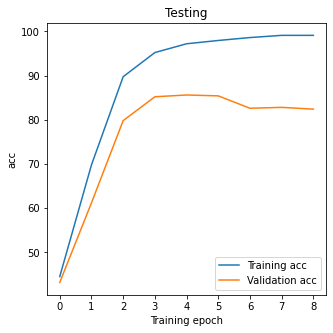

In [ ]:
training_stats_1, embedding = load_training_info(filename+"_1")
plot_stats(training_stats_1, name="Testing")
print(embedding)
print(node_features)

In [ ]:
# Loading stored model weights
model = GATModelWrapper(in_channels = node_features.shape[-1], hidden_channels = node_features.shape[-1], num_layers=1, out_channels=num_classes, v2=True)
model.load_state_dict(torch.load(file_path+filename+"/"+"GATV2_1_model.pt"))
model.eval()

GATModelWrapper(1433, 7, num_layers=1)

- Plot graph with average training stats
- Save node embeddings for each run
- Save training stats for each run
- Save test accuracy for each run


In [14]:
# Code taken from L45 practical notebook
def train_gnn_cora(X, edge_indices, y, mask, model, optimiser, loader):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_gnn_cora(X, edge_indices, y, mask, model, num_classes, loader):
    model.eval()
    z = model()
    acc = model.test(z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      z[cora_data.val_mask], cora_data.y[cora_data.val_mask],
                      max_iter=150)
    #y_out = z[cora_data.train_mask]
    y_hat = z[cora_data.val_mask].to(device)
    y = cora_data.y[cora_data.val_mask].to(device)
    
    #model.eval()
    #y_out, node_embeddings = model(X, edge_indices)
    #y_hat = y_out[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)

    # calculate per class accuracy
    values, counts = torch.unique(y_hat[y_hat == y.data], return_counts=True)
    per_class_counts = torch.zeros(num_classes)
    # allocate the number of counts per class
    for i, x in enumerate(values):
      per_class_counts[x] = counts[i]
    per_class_counts = per_class_counts.to(device)
    # find total number of data points per class in the split
    total_per_class = torch.bincount(y.data).to(device)
    per_class_accuracy = torch.div(per_class_counts, total_per_class)

    return accuracy, per_class_accuracy
    
# Training loop
def train_eval_loop_gnn_cora(model, edge_indices, train_x, train_y, train_mask, valid_x, valid_y, valid_mask, 
                             test_x, test_y, test_mask, num_classes, seed, filename, loader):
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_gnn_cora(train_x, edge_indices, train_y, train_mask, model, optimiser, loader)
        train_acc, train_class_acc = evaluate_gnn_cora(train_x, edge_indices, train_y, train_mask, model, num_classes, loader)
        valid_acc, valid_class_acc = evaluate_gnn_cora(valid_x, edge_indices, valid_y, valid_mask, model, num_classes, loader)
        if epoch % 10 == 0 or epoch == (NUM_EPOCHS-1):
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f} validation accuracy: {valid_acc:.3f}")
            #print("Per class train accuracy: ", train_class_acc)
            #print("Per class val accuracy: ", valid_class_acc)
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)

    # Lets look at our final test performance
    # Only need to get the node embeddings once, take from the training evaluation call
    test_acc, test_class_acc = evaluate_gnn_cora(test_x, edge_indices, test_y, test_mask, model, num_classes, loader)
    print(f"Our final test accuracy for the GNN is: {test_acc:.3f}")
    print("Final per class accuracy on test set: ", test_class_acc)

    # Save training stats if on final iteration of the run
    #save_training_info(training_stats, node_embeddings, filename+"_"+str(seed))
    # Save final results
    final_results_list = [seed, test_acc, test_class_acc, train_class_acc, valid_class_acc]
    save_final_results(final_results_list, filename)
    # Save final model weights incase we want to do further inference later
    torch.save(model.state_dict(), file_path+filename+"_" + str(seed) + "_model.pt")
    return training_stats

In [15]:
from torch_geometric.nn import Node2Vec

# Get the edge indices and node features for our model
edge_indices = cora_data.edge_index
node_features = cora_data.x

# Get masks and training labels for each split
train_mask = cora_data.train_mask
train_y = cora_data.y[train_mask]
valid_mask = cora_data.val_mask
valid_y = cora_data.y[valid_mask]
test_mask = cora_data.test_mask
test_y = cora_data.y[test_mask]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_classes = 7
# CHANGE: To name of model being tested
filename = "Node2Vec"
# use 30 seeds which have been randomly generated using seed_list = [np.random.randint(4294967296 - 1) for i in range(30)]
seeds = [4193977854, 1863727779, 170173784, 2342954646, 116846604, 2105922959, 2739899259, 1024258131, 806299656, 880019963, 1818027900, 2135956485, 3710910636, 1517964140, 4083009686, 2455059856, 400225693, 89475662, 361232447, 3647665043, 1221215631, 2036056847, 1860537279, 516507873, 3692371949, 3300171104, 2794978777, 3303475786, 2952735006, 572297925]

# create folder for saving all model info into if it does not exist already
if not os.path.exists(file_path+filename+"/"):
  os.mkdir(file_path+filename+"/")

for seed in seeds:
  set_seeds(seed)
  # Create the model
  #model = GATModelWrapper(in_channels = node_features.shape[-1], hidden_channels = node_features.shape[-1], num_layers=1, out_channels=num_classes, v2=True)
  model = Node2Vec(cora_data.edge_index.to(device), embedding_dim=128, walk_length=20,
                     context_size=10, walks_per_node=10,
                     num_negative_samples=1, p=1, q=1, sparse=True).to(device)
  loader = model.loader(batch_size=128, shuffle=True,
                          num_workers=0)
  optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

  #train_stats_cora = train_eval_loop_gnn_cora(model, edge_indices, node_features, train_y, train_mask, 
                                            #node_features, valid_y, valid_mask, node_features, test_y, test_mask, num_classes, seed, filename+"/"+filename, loader)

  def train():
      model.train()
      total_loss = 0
      for pos_rw, neg_rw in loader:
          optimizer.zero_grad()
          loss = model.loss(pos_rw.to(device), neg_rw.to(device))
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          #print(loss.data)
      #epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
      return total_loss / len(loader)

  @torch.no_grad()
  def test():
    model.eval()
    z = model()
    acc_train = model.test(z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      max_iter=150)
    acc_val = model.test(z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      z[cora_data.val_mask], cora_data.y[cora_data.val_mask],
                      max_iter=150)
    acc_test = model.test(z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      z[cora_data.test_mask], cora_data.y[cora_data.test_mask],
                      max_iter=150)
    y_train = cora_data.y[cora_data.train_mask].to(device)
    y_hat_train = z[cora_data.train_mask].to(device)
    y_val = cora_data.y[cora_data.val_mask].to(device)
    y_hat_val = z[cora_data.val_mask].to(device)
    y_test = cora_data.y[cora_data.test_mask].to(device)
    y_hat_test = z[cora_data.test_mask].to(device)

    loss_train = F.cross_entropy(y_hat_train, y_train)
    loss_val = F.cross_entropy(y_hat_val, y_val)
    loss_test = F.cross_entropy(y_hat_test, y_test)

    return acc_train, acc_val, acc_test, loss_train, loss_val, loss_test

  for epoch in range(1, 40):
    loss = train()
    acc_train, acc_val, acc_test, loss_train, loss_val, loss_test = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc_train: {acc_train:.4f}, Acc_val: {acc_val:.4f}, Acc_test: {acc_test:.4f}')

  # Run training loop
  #print("TRAINING WITH SEED: ", str(seed))
  #train_stats_cora = train_eval_loop_gnn_cora(model, edge_indices, node_features, train_y, train_mask, 
  #                                          node_features, valid_y, valid_mask, node_features, test_y, test_mask, num_classes, seed, filename+"/"+filename)
  #plot_stats(train_stats_cora, name=filename+"_Cora")

SETTING SEEDS TO:  4193977854
Epoch: 01, Loss: 8.1413, Acc_train: 0.4462, Acc_val: 0.2460, Acc_test: 0.2290
Epoch: 02, Loss: 6.0991, Acc_train: 0.5000, Acc_val: 0.2900, Acc_test: 0.2680
Epoch: 03, Loss: 4.9834, Acc_train: 0.5472, Acc_val: 0.3300, Acc_test: 0.3110
Epoch: 04, Loss: 4.1355, Acc_train: 0.6051, Acc_val: 0.3860, Acc_test: 0.3730
Epoch: 05, Loss: 3.4939, Acc_train: 0.6416, Acc_val: 0.4120, Acc_test: 0.4220
Epoch: 06, Loss: 2.9725, Acc_train: 0.6796, Acc_val: 0.4760, Acc_test: 0.4520
Epoch: 07, Loss: 2.5564, Acc_train: 0.7219, Acc_val: 0.5080, Acc_test: 0.4960
Epoch: 08, Loss: 2.2324, Acc_train: 0.7575, Acc_val: 0.5200, Acc_test: 0.5180
Epoch: 09, Loss: 1.9625, Acc_train: 0.7765, Acc_val: 0.5300, Acc_test: 0.5390
Epoch: 10, Loss: 1.7468, Acc_train: 0.7997, Acc_val: 0.5480, Acc_test: 0.5650
Epoch: 11, Loss: 1.5779, Acc_train: 0.8146, Acc_val: 0.5700, Acc_test: 0.5790
Epoch: 12, Loss: 1.4357, Acc_train: 0.8237, Acc_val: 0.5820, Acc_test: 0.6120
Epoch: 13, Loss: 1.3248, Acc_train

KeyboardInterrupt: ignored

# Similarity tests

https://github.com/SGDE2020/embedding_stability/blob/master/similarity_tests/similarity_tests.py